# Solving the 2-matching problem using a Branch-and-Price algorithm with PySCIPOpt

The *2-matching problem* is defined in terms of a graph $G=(V,E)$  and costs $c : E \to \mathbb{R}_{\geq 0}$.
It asks for a subset $M \subseteq E$ such that each vertex is incident to two edges and $c(M)$ is minimized.
We consider the Eucliean version, where $V$ is embedded into the plane via $p : V \to \mathbb{R}^{2}$ and
$$
c(\{u, v\}) = \| p(u) - p(v) \|_2
$$

We begin by generating a random instance:

In [1]:
import pyscipopt
from pyscipopt import Model, quicksum

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
matplotlib.rcParams['axes.titlesize'] = 20

In [2]:
n = 100

np.random.seed(42)
coordinates = np.random.random((n, 2))

Since the instance is embedded into the plane, we can plot it easily:

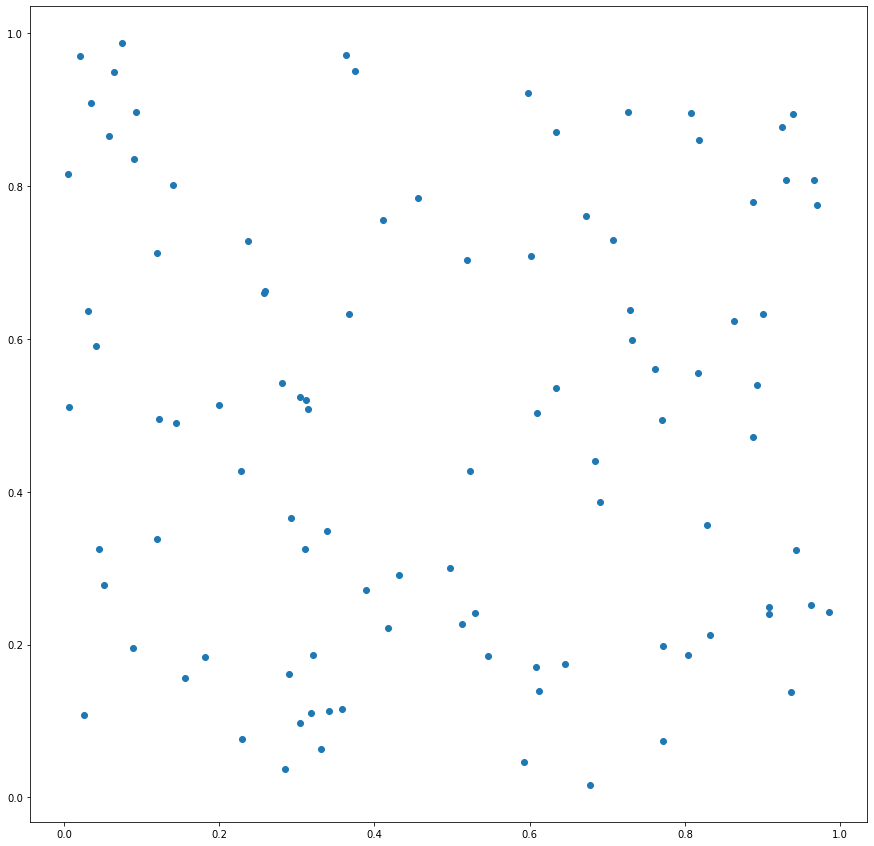

In [3]:
plt.scatter(coordinates[:, 0], coordinates[:,1])

# Formulating the problem as an integer program

In [4]:
def vertices(n):
    return range(n)

def edges(n):
    return [(i, j) for i in vertices(n) for j in vertices(n) if i < j]

In [5]:
def dist(coordinates, i, j):
    dx = coordinates[i, 0] - coordinates[j, 0]
    dy = coordinates[i, 1] - coordinates[j, 1]
    return np.hypot(dx, dy)

In [6]:
def create_incidences(vertices, edges):
    incidences = {i:[] for i in vertices}
    
    for edge in edges:
        (i, j) = edge
        incidences[i].append(edge)
        incidences[j].append(edge)
        
    return incidences

We add one variable for each $e \in E$ to the model. The variables are `binary` and have an objective according to $c$:

In [7]:
def create_variables(model, edges, coordinates):
    return {edge:model.addVar(name=f"x_{edge}", vtype="B", obj=dist(coordinates, *edge)) 
            for edge in edges}


We add the constraint $\delta(v) = 2$ for all vertices in $V$:

In [8]:
def create_constraints(model, n, variables, **props):
    edges = list(variables.keys())
    incidences = create_incidences(vertices(n), edges)
    cons = {}
    for (v, i) in incidences.items():
        cons[v] = model.addCons(quicksum((variables[edge] for edge in i)) == 2, **props)
    
    return cons
        

In [9]:
model = Model()
model.redirectOutput()

variables  = create_variables(model, edges(n), coordinates)

_ = create_constraints(model, n, variables)

 We optimize the model and print the final optimization status:

In [10]:
model.optimize()

model.getStatus()

presolving:
   (0.1s) running MILP presolver
   (0.1s) MILP presolver found nothing
   (0.3s) probing: 51/4950 (1.0%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.3s) probing aborted: 50/50 successive totally useless probings
   (0.3s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.3s) no symmetry present
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 4950 variables (4950 bin, 0 int, 0 impl, 0 cont) and 100 constraints
    100 constraints of type <linear>
Presolving Time: 0.23

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
p 0.3s|     1 |     0 |     0 |     - |   locks|   0 |4950 | 100 | 100 |   0 |  0 |   0 |   0 | 0.000000e+

'optimal'

We convert the solution vector to obtain the actual set $M$ forming the 2-matching:

In [11]:
solution = [edge for (edge, variable) in variables.items() if round(model.getVal(variable)) == 1]

# Plotting the solution

In order inspect the solution, we plot both the points and the segments formed by $M$:

In [12]:
def plot_sol(sol, coordinates):
    x = coordinates[:,0]
    y = coordinates[:,1]
    lines = [[(x[i], y[i]), (x[j], y[j])] for (i, j) in solution]

    plt.scatter(x, y)

    lc = matplotlib.collections.LineCollection(lines, linewidths=2)

    ax = plt.gca()

    ax.add_collection(lc)
    ax.autoscale()
    
    obj = sum(dist(coordinates, *edge) for edge in sol)
    plt.title(f"A solution with objective {obj}")
    
    plt.show()


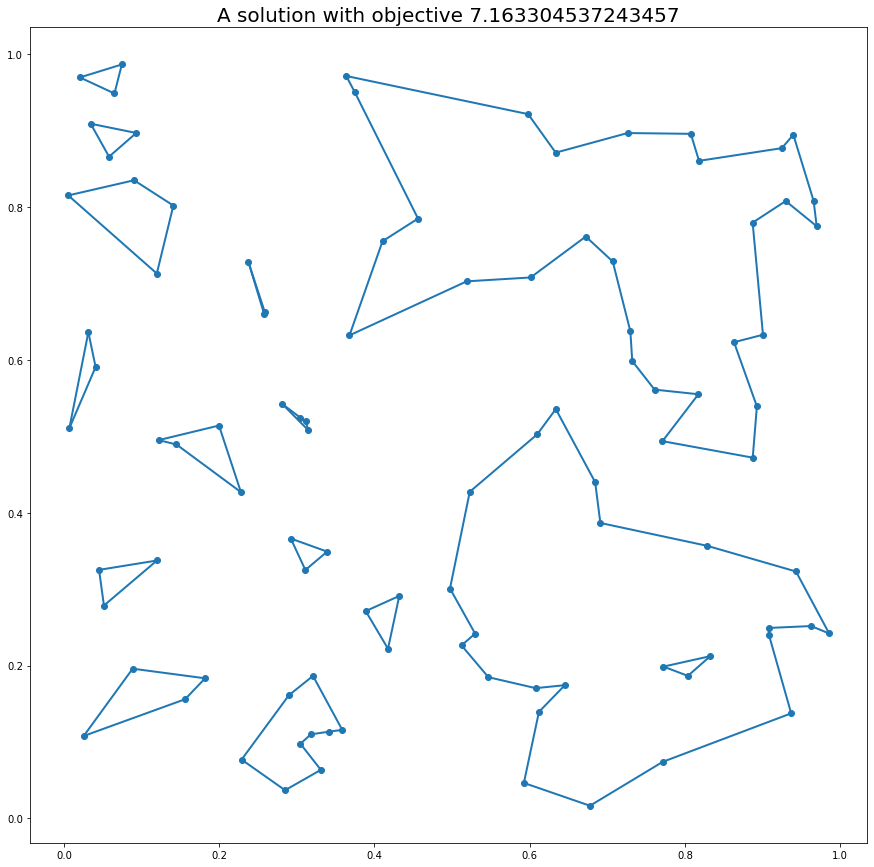

In [13]:
plot_sol(solution, coordinates)

# Introducing core sets

In order to speed up computation, reduce the set of variables to those likely to be in the optimal set $M$. We choose the $k=5$ shortest incident edges for each vertex:

In [14]:
def core_set(n, k, coordinates):
    incidences = create_incidences(vertices(n), edges(n))
    
    core_set = set()
    
    for (i, inc) in incidences.items():
        inc.sort(key=lambda edge: dist(coordinates, *edge))
        core_set.update(inc[:k])
    
    return core_set


In [15]:
k = 5

This choice significantly reduces the number of problem variables:

In [16]:
len(edges(n)), len(core_set(n, k, coordinates))

(4950, 310)

We resolve based on the core set and plot the resulting solution:

In [17]:
model = Model()
model.redirectOutput()

variables = create_variables(model, core_set(n, k, coordinates), coordinates)

_ = create_constraints(model, n, variables)

In [18]:
model.optimize()

model.getStatus()

presolving:
   (0.0s) running MILP presolver
   (0.0s) MILP presolver found nothing
   (0.0s) probing: 51/310 (16.5%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
   (0.0s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (0.0s) no symmetry present
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 310 variables (310 bin, 0 int, 0 impl, 0 cont) and 100 constraints
    100 constraints of type <linear>
Presolving Time: 0.01

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
p 0.0s|     1 |     0 |     0 |     - |   locks|   0 | 310 | 110 | 100 |   0 |  0 |  10 |   0 | 0.000000e+00

'optimal'

In [19]:
solution = [edge for (edge, variable) in variables.items() if round(model.getVal(variable)) == 1]

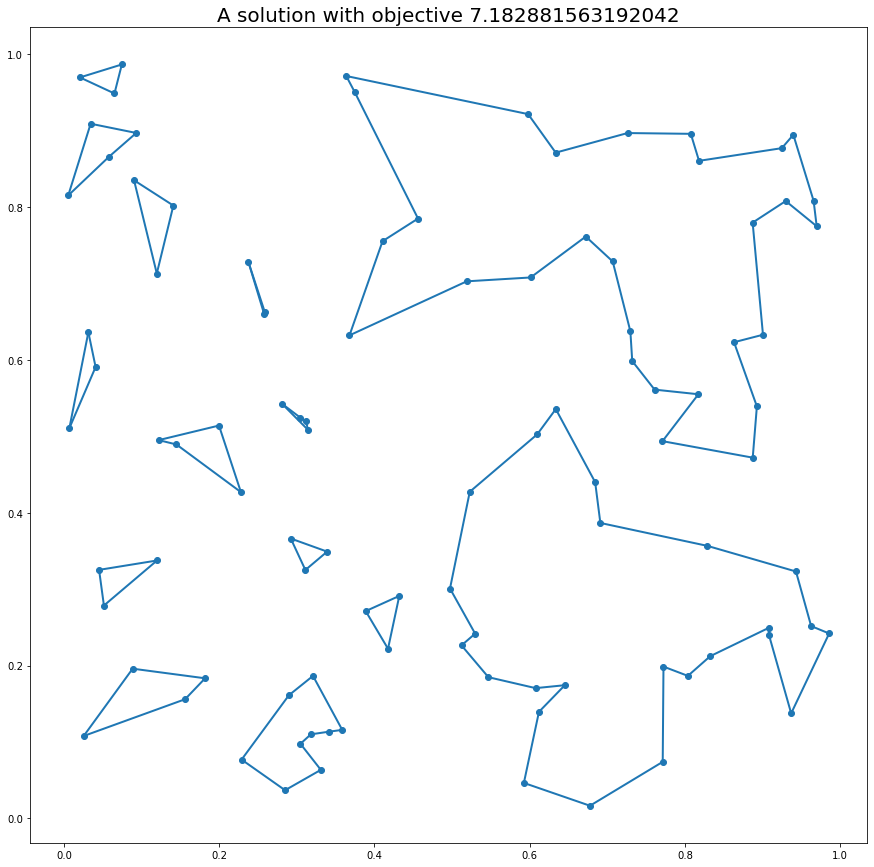

In [20]:
plot_sol(solution, coordinates)

The solution is found much more quickly, but it is not optimal.

# Adding a pricer

In order to systematically generate variables, we implement a variable pricer and add it to the model. This requires the implementation of a callback method which solves the pricing problem and adds one or more variables with negative reduced costs to the model.

First, determine the reduced costs using the `getDualsolLinear` function of the model:

In [21]:
def reduced_costs(coordinates, model, constraints):
    
    def cost_value(edge):
        i, j = edge
        obj = dist(coordinates, *edge)
        
        return obj - (model.getDualsolLinear(constraints[i]) + model.getDualsolLinear(constraints[j]))
    
    return cost_value


def farkas_costs(model, constraints):
    
    def cost_value(edge):
        i, j = edge
        return - (model.getDualfarkasLinear(constraints[i]) + model.getDualfarkasLinear(constraints[j]))
    
    return cost_value

Adding a variable consists of two steps:

1. Add the variable to the problem
2. Set the non-zero coefficients of the corresponding column

In [22]:
def add_variable(model, coordinates, constraints, edge):
    i, j = edge
    obj = dist(coordinates, *edge)
        
    print(f"Generating variable for {str(edge)}")
        
    var = model.addVar(name=f"x_{edge}", vtype="B", obj=obj, pricedVar=True)
        
    model.addConsCoeff(constraints[i], var, 1.)
    model.addConsCoeff(constraints[j], var, 1.)
            
    return var

In [23]:
class EdgePricer(pyscipopt.scip.Pricer):
    
    def __init__(self, n, coordinates, variables, model, constraints):
        self.constraints = constraints
        self.num_vertices = n
        self.coordinates = coordinates
        self.model = model
        self.variables = {edge:var for edge, var in variables.items()}
        
    def add_variable(self, edge):
        i, j = edge
        obj = dist(self.coordinates, *edge)
        
        print(f"Generating variable for {str(edge)}")
        
        var = self.model.addVar(name=f"x_{edge}", vtype="B", obj=obj, pricedVar=True)
        
        self.model.addConsCoeff(self.transformed_constraints[i], var, 1.)
        self.model.addConsCoeff(self.transformed_constraints[j], var, 1.)
            
        self.transformed_variables[edge] = var
        
        
    def generate_variables(self, costs):
        for edge in edges(self.num_vertices):
            if edge in self.transformed_variables:
                continue

            cost = costs(edge)
            
            if not self.model.isFeasNegative(cost):
                continue

            var = add_variable(self.model, self.coordinates, self.transformed_constraints, edge)
            
            self.transformed_variables[edge] = var
            
            return
        
    def pricerinit(self):
        self.transformed_constraints = {i:model.getTransformedCons(c) 
                                        for (i, c) in self.constraints.items()}
        
        self.transformed_variables = {i:model.getTransformedVar(v) 
                                      for (i, v) in self.variables.items()}
        
    def pricerfarkas(self):
        costs = farkas_costs(self.model, self.transformed_constraints)
        
        self.generate_variables(costs)
            
        #return a result array
        return {"result": pyscipopt.SCIP_RESULT.SUCCESS}
    
    def pricerredcost(self):
        costs = reduced_costs(self.coordinates, self.model, self.transformed_constraints)

        self.generate_variables(costs)
            
        #return a result array
        return {"result": pyscipopt.SCIP_RESULT.SUCCESS}


We add the pricer to the model and resolve. It is important to enable pricing and make the constraints `modifiable`.

In [24]:
model = Model(enablepricing=True)
model.redirectOutput()

k = 5

variables = create_variables(model, core_set(n, k, coordinates), coordinates)

constraints = create_constraints(model, n, variables, modifiable=True)

pricer = EdgePricer(n, coordinates, variables, model, constraints)

model.includePricer(pricer, "edge_pricer", "Generates edge variables for the 2-matching problem")

In [25]:
model.optimize()

presolving:
   (0.0s) probing: 51/310 (16.5%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 310 variables (310 bin, 0 int, 0 impl, 0 cont) and 100 constraints
    100 constraints of type <linear>
Presolving Time: 0.00

Generating variable for (14, 38)
 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.1s|     1 |     0 |   169 |     - |  2207k |   0 | 311 | 100 | 100 |   0 |  0 |   0 |   0 |      --      |      --      |    Inf | unknown
Generating variable for (38, 89)
  0.2s|     1 |     0 |   174 |     - |  2207k |   0 | 312 | 100 | 100 |   0 |  0 |   0 |   0 | 7.072974e

In [26]:
len(pricer.transformed_variables)

349

# Farkas pricing

To demonstrate the Farkas pricing we restrict the size of the core sets such that the initial problem is infeasible.

In [27]:
model = Model(enablepricing=True)
model.redirectOutput()

k = 1

variables = create_variables(model, core_set(n, k, coordinates), coordinates)

constraints = create_constraints(model, n, variables, modifiable=True)

pricer = EdgePricer(n, coordinates, variables, model, constraints)

model.includePricer(pricer, "edge_pricer", "Generates edge variables for the 2-matching problem")

model.optimize()

presolving:
   (0.0s) probing: 51/68 (75.0%) - 0 fixings, 0 aggregations, 0 implications, 0 bound changes
   (0.0s) probing aborted: 50/50 successive totally useless probings
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 68 variables (68 bin, 0 int, 0 impl, 0 cont) and 100 constraints
    100 constraints of type <linear>
Presolving Time: 0.01

Generating variable for (0, 79)
 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
  0.0s|     1 |     0 |    60 |     - |  1073k |   0 |  69 | 100 | 100 |   0 |  0 |   0 |   0 |      --      |      --      |    Inf | unknown
Generating variable for (0, 21)
Generating variable for (1, 21)
Generating variable for (1, 36)
Generating variable for (2, 21)
Generating var

In [28]:
len(pricer.transformed_variables)

1352

In [29]:
solution = [edge for (edge, variable) in pricer.transformed_variables.items() if round(model.getVal(variable)) == 1]

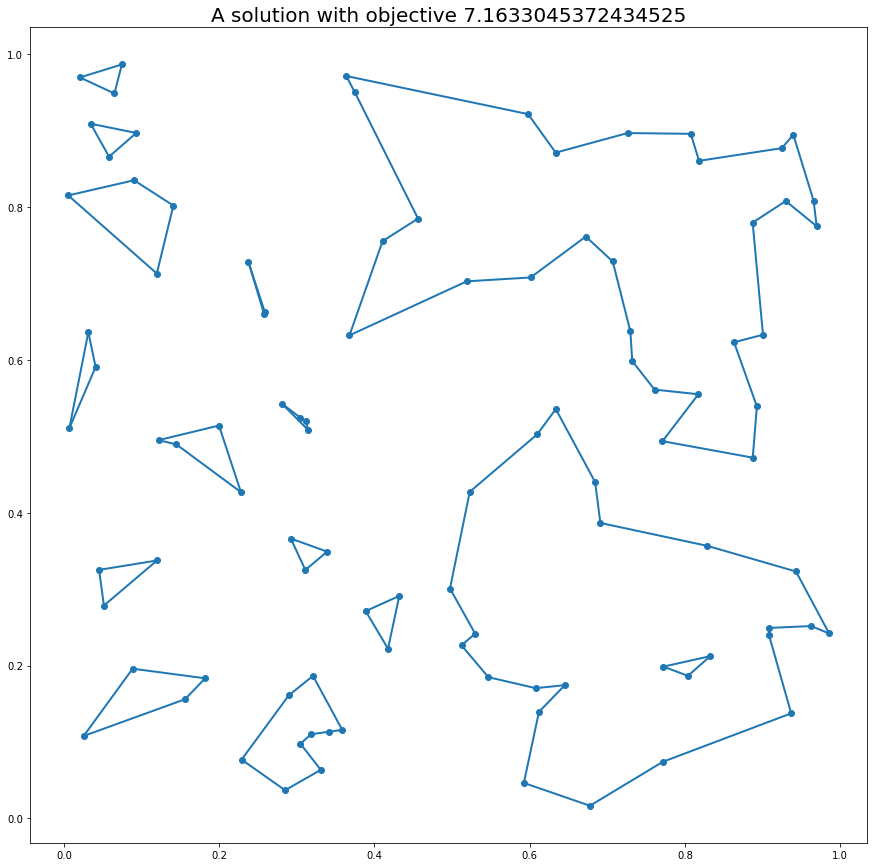

In [30]:
plot_sol(solution, coordinates)

# Results

Why is this significantly slower?

No cuts are added to the problem, so the problem is no longer solved in the root node of the Branch-and-Bound tree. We need to augment the algorithm to a Branch-Price-and-Cut method...